In [16]:
import os
import pickle
from typing import List, Optional

from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack.components.generators.chat import OpenAIChatGenerator
from typing import List, Dict
from nltk.tokenize import word_tokenize
from haystack import Pipeline, component, Document                                     
from haystack_integrations.document_stores.chroma import ChromaDocumentStore  
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.rankers import TransformersSimilarityRanker
from sklearn.metrics import accuracy_score

import re
import pickle
from typing import List, Dict, Optional

from nltk.tokenize import word_tokenize

from haystack import Pipeline, component
from haystack.dataclasses import Document, ChatMessage
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack.utils import Secret

# ──────────────────────────────────────────────────────────────────────────────
# 0️⃣ Компоненты
# ──────────────────────────────────────────────────────────────────────────────

@component
class QueryClassifierLLM:
    """
    Классифицирует, нужен ли поиск (RAG) для запроса.
    """
    def __init__(self, generator: OpenAIChatGenerator):
        self.generator = generator
        self.template = """
Ты — классификатор запросов по базе знаний.
Если запрос требует поиска — ответь 'true'. Если можно ответить без поиска — 'false'.

Примеры:
Запрос: "Привет"
Ответ: false

Запрос: "Как дела?"
Ответ: false

Запрос: "Что такое GDPR?"
Ответ: true

Запрос: "Сколько дней отпуска положено сотрудникам?"
Ответ: true

Теперь классифицируй:
Запрос: "{{ query }}"
Ответ:
""".strip()

    @component.output_types(need_search=bool)
    def run(self, query: str) -> Dict[str, bool]:
        prompt = self.template.replace("{{ query }}", query)
        msg = ChatMessage.from_user(prompt)
        out = self.generator.run([msg])
        replies = out.get("replies", [])
        text = replies[0].text.strip().lower() if replies else ""
        return {"need_search": text.startswith("true")}


@component
class QueryDecomposerLLM:
    """
    Через LLM решает, нужно ли декомпозировать запрос, и генерирует subqueries.
    """
    def __init__(self, generator: OpenAIChatGenerator):
        self.generator = generator
        self.check_template = """
Ты — эксперт по обработке запросов.
Если запрос сложный и стоит разбить его на под‑вопросы — 'true', иначе — 'false'.

Примеры:
Запрос: "Расскажи о новых политиках отпуска и сколько дней теперь положено?"
Ответ: true

Запрос: "Что такое GDPR?"
Ответ: false

Теперь оцени:
Запрос: "{{ query }}"
Ответ:
""".strip()
        self.decomp_template = """
Ты — специалист по декомпозиции.
Разбей запрос на короткие независимые под‑вопросы, каждый на новой строке.

Примеры:
Оригинал: "Расскажи о новых политиках отпуска и сколько дней теперь положено?"
- Расскажи о новых политиках отпуска.
- Сколько дней отпуска теперь положено?

Теперь разбей:
Оригинал: "{{ query }}"
""".strip()

    @component.output_types(subqueries=List[str])
    def run(self, query: str) -> Dict[str, List[str]]:
        # 1) Проверяем необходимость разбивки
        check_prompt = self.check_template.replace("{{ query }}", query)
        check_msg = ChatMessage.from_user(check_prompt)
        check_out = self.generator.run([check_msg])
        dec = check_out.get("replies", [])
        needs = dec[0].text.strip().lower().startswith("true") if dec else False

        if not needs:
            return {"subqueries": [query]}

        # 2) Генерируем под‑вопросы
        decomp_prompt = self.decomp_template.replace("{{ query }}", query)
        decomp_msg = ChatMessage.from_user(decomp_prompt)
        decomp_out = self.generator.run([decomp_msg])
        raw = decomp_out.get("replies", [])[0].text or ""
        parts = [line.strip("- ").strip() for line in raw.splitlines() if line.strip()]
        return {"subqueries": parts}

@component
class QueryCleaner:
    """
    Приводит строку к нижнему регистру, токенизирует и оставляет только слово-числовые токены.
    """
    @component.output_types(query=str)
    def run(self, query: str) -> Dict[str, str]:
        q = query.lower()
        tokens = word_tokenize(q)
        filt = [t for t in tokens if re.fullmatch(r"\w+", t)]
        return {"query": " ".join(filt)}

@component
class PickledBM25Retriever:
    """
    Sparse Retriever на основе заранее построенного BM25-индекса в pickle.
    """
    def __init__(
        self,
        document_store: ChromaDocumentStore,
        path_to_pickle: str,
        top_k: int = 5
    ):
        self.top_k = top_k
        self.path = path_to_pickle
        # загрузка всех документов для быстрого доступа
        all_docs = document_store.filter_documents(filters={})
        self.doc_map = {d.id: d for d in all_docs}

    @component.output_types(documents=List[Document])
    def run(self, query: str, top_k: Optional[int] = None) -> Dict[str, List[Document]]:
        k = top_k or self.top_k
        with open(self.path, "rb") as f:
            bm25, doc_ids = pickle.load(f)
        tokens = word_tokenize(query.lower())
        scores = bm25.get_scores(tokens)
        top_idxs = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:k]
        docs = [self.doc_map[doc_ids[i]] for i in top_idxs if doc_ids[i] in self.doc_map]
        return {"documents": docs}

import logging
from typing import List, Dict
from haystack.dataclasses import ChatMessage
from haystack import component, Document

# Настройка логирования
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

@component
class MultiQueryHandler:
    """
    Для списка subqueries выполняет поиск+генерацию, а затем агрегирует ответы с логированием.
    """
    def __init__(
        self,
        bm25,
        chroma,
        joiner,
        ranker,
        prompt_builder,
        generator
    ):
        self.bm25 = bm25
        self.chroma = chroma
        self.joiner = joiner
        self.ranker = ranker
        self.pb = prompt_builder
        self.gen = generator
        self.logger = logging.getLogger(self.__class__.__name__)

    @component.output_types(answer=str)
    def run(self, multi: List[str], original_query: str) -> Dict[str, str]:
        self.logger.debug("Starting MultiQueryHandler.run: original_query='%s', multi=%s", original_query, multi)
        parts = []
        # Ограничиваем количество подзапросов тремя
        limited_multi = multi[:3]
        if len(multi) > 3:
            self.logger.debug("Ограничиваем число подзапросов с %d до 3", len(multi))

        for sq in limited_multi:
            self.logger.debug("Processing subquery: '%s'", sq)
            try:
                # retrieval
                d1 = self.bm25.run(query=sq)["documents"]
                self.logger.debug("BM25 returned %d documents", len(d1))
                d2 = self.chroma.run(query=sq)["documents"]
                self.logger.debug("Chroma returned %d documents", len(d2))

                # join + rank (reciprocal rank fusion)
                jdocs = self.joiner.run(documents=[d1, d2])["documents"]
                self.logger.debug("After joiner: %d documents", len(jdocs))
                rdocs = self.ranker.run(documents=jdocs, query=sq)["documents"]
                self.logger.debug("After ranker: %d documents", len(rdocs))

                # Ограничиваем размер документов до 200 символов
                truncated_docs: List[Document] = []
                for doc in rdocs:
                    content = doc.content or ""
                    truncated_content = content[:200] if len(content) > 200 else content
                    truncated_docs.append(Document(content=truncated_content, id=doc.id, score=doc.score, meta=doc.meta))
                self.logger.debug("Документы после усечения: %s", [len(d.content) for d in truncated_docs])
            
                # prompt & generation
                messages = self.pb.run(query=sq, documents=truncated_docs)["prompt"]
                self.logger.debug("Generated prompt messages: %s", messages)
                out = self.gen.run(messages)
                self.logger.debug("Generator output: %s", out)
                text = out.get("replies", [])[0].text or ""
                parts.append(text)
            except Exception as e:
                self.logger.error("Error processing subquery '%s': %s", sq, e, exc_info=True)

        if not parts:
            self.logger.debug("No parts generated, returning default message.")
            return {"answer": "Извините, по вашему запросу ничего не найдено."}

        # финальная агрегация
        summary = (
            f"На основе ответов на части вопроса «{original_query}» "
            "собери единый связный ответ:\n"
        )
        for i, p in enumerate(parts, 1):
            summary += f"Часть {i}: {p}\n"
        self.logger.debug("Aggregation prompt: %s", summary)
        sum_msg = ChatMessage.from_user(summary)
        sum_out = self.gen.run([sum_msg])
        agg = sum_out.get("replies", [])[0].text or ""
        self.logger.debug("Final aggregated answer: %s", agg)
        return {"answer": agg}


@component
class ResponseSelector:
    """
    Выбирает финальный ответ из:
      - multi_answer (если задан)
      - иначе rag_replies[0]
      - иначе chat_replies[0]
    """
    @component.output_types(answer=str)
    def run(
        self,
        chat_replies: Optional[List[ChatMessage]] = None,
        rag_replies:  Optional[List[ChatMessage]] = None,
        multi_answer: Optional[str]            = None
    ) -> dict:
        if multi_answer:
            return {"answer": multi_answer}
        if rag_replies:
            return {"answer": rag_replies[0].text}
        if chat_replies:
            return {"answer": chat_replies[0].text}
        return {"answer": ""}

# ──────────────────────────────────────────────────────────────────────────────
# 1️⃣ Настройка моделей и ретриверов
# ──────────────────────────────────────────────────────────────────────────────
# MODEL_NAME = "hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q8_0"
MODEL_NAME = "hf.co/IlyaGusev/saiga_yandexgpt_8b_gguf:Q4_0"
gen_conv = OpenAIChatGenerator(
    model=MODEL_NAME,
    api_key=Secret.from_token("ollama"),
    api_base_url="http://localhost:11434/v1",
    generation_kwargs={"temperature": 0.8, "max_tokens": 500, "timeout": 240}
)

gen_rag = OpenAIChatGenerator(
    model=MODEL_NAME,
    api_key=Secret.from_token("ollama"),
    api_base_url="http://localhost:11434/v1",
    generation_kwargs={"temperature": 0.8, "max_tokens": 500, "timeout": 240}
)

gen_multi = OpenAIChatGenerator(
    model=MODEL_NAME,
    api_key=Secret.from_token("ollama"),
    api_base_url="http://localhost:11434/v1",
    generation_kwargs={"temperature": 0.8, "max_tokens": 500, "timeout": 240}
)

ds        = ChromaDocumentStore(persist_path="../data/chroma_index")
bm25      = PickledBM25Retriever(ds, "../data/bm25.pkl", top_k=5)
chroma    = ChromaQueryTextRetriever(document_store=ds, top_k=5)
joiner    = DocumentJoiner(join_mode="reciprocal_rank_fusion", top_k=10)
ranker = TransformersSimilarityRanker(model="cross-encoder/ms-marco-TinyBERT-L-2-v2", top_k=5)
ranker.warm_up()

# PromptBuilder для простой беседы (no_search)
conv_pb = ChatPromptBuilder(
    template=[
        ChatMessage.from_system("Ты — дружелюбный помощник."),
        ChatMessage.from_user("{{ query }}")
    ],
    required_variables=["query"]
)

# PromptBuilder для RAG‑ответа (single + multi parts)
rag_pb = ChatPromptBuilder(
    template=[
        ChatMessage.from_system("Ты — эксперт по базе знаний."),
        ChatMessage.from_user(
            "Вопрос: {{ query }}\n\n"
            "Контекст:\n{% for doc in documents %}- {{ doc.content }}\n{% endfor %}\n\n"
            "Ответь подробно и укажи источники:"
        )
    ],
    required_variables=["query", "documents"]
)

# multi_handler = MultiQueryHandler(
#     bm25=bm25,
#     chroma=chroma,
#     joiner=joiner,
#     ranker=ranker,
#     prompt_builder=rag_pb,
#     generator=gen_nulti
# )


# ──────────────────────────────────────────────────────────────────────────────
# 2️⃣ Сборка Pipeline
# ──────────────────────────────────────────────────────────────────────────────
pipe = Pipeline()

# 2.1 Classifier → router1
pipe.add_component("classifier", QueryClassifierLLM(generator=gen_conv))
pipe.add_component("router1", ConditionalRouter(routes=[
    {"condition": "{{ need_search == false }}",
     "output": "{{ query }}", "output_name": "no_search", "output_type": str},
    {"condition": "{{ need_search == true  }}",
     "output": "{{ query }}", "output_name": "to_search", "output_type": str},
]))
pipe.connect("classifier.need_search", "router1.need_search")

# 2.2 no_search: беседа без поиска
pipe.add_component("conv_pb",  conv_pb)
pipe.add_component("chat_gen", gen_conv)
pipe.connect("router1.no_search", "conv_pb.query")
pipe.connect("conv_pb.prompt",  "chat_gen.messages")

# 2.3 to_search → декомпозиция
pipe.add_component("decomposer", QueryDecomposerLLM(generator=gen_rag))
pipe.connect("router1.to_search", "decomposer.query")

pipe.add_component("router2", ConditionalRouter(routes=[
    {"condition": "{{ subqueries|length > 1 }}",
     "output": "{{ subqueries }}",     "output_name": "multi",  "output_type": list[str]},
    {"condition": "{{ subqueries|length <= 1 }}",
     "output": "{{ subqueries[0] }}", "output_name": "single","output_type": str},
]))
pipe.connect("decomposer.subqueries", "router2.subqueries")

# 2.4 single → поиск + генерация
pipe.add_component("cleaner", QueryCleaner())
pipe.add_component("bm25",    bm25)
pipe.add_component("chroma",  chroma)
pipe.add_component("joiner",  joiner)
pipe.add_component("ranker",  ranker)
pipe.add_component("rag_pb",  rag_pb)
pipe.add_component("rag_gen", gen_rag)

pipe.connect("router2.single",   "cleaner.query")
pipe.connect("cleaner.query",    "bm25.query")
pipe.connect("cleaner.query",    "chroma.query")
pipe.connect("bm25.documents",   "joiner.documents")
pipe.connect("chroma.documents", "joiner.documents")
pipe.connect("joiner.documents", "ranker.documents")

pipe.connect("router2.single",   "rag_pb.query")
pipe.connect("ranker.documents", "rag_pb.documents")
pipe.connect("rag_pb.prompt",    "rag_gen.messages")

# 2.5 multi → MultiQueryHandler
multi_handler = MultiQueryHandler(
    bm25=bm25,
    chroma=chroma,
    joiner=pipe.get_component("joiner"),
    ranker=pipe.get_component("ranker"),
    prompt_builder=rag_pb,
    generator=gen_multi
)
pipe.add_component("multi_handler", multi_handler)
# pipe.add_component("multi_handler", )
pipe.connect("router2.multi",     "multi_handler.multi")
pipe.connect("router1.to_search", "multi_handler.original_query")

# ──────────────────────────────────────────────────────────────────────────────
# после всех остальных add_component/ connect(...)…
# ──────────────────────────────────────────────────────────────────────────────
pipe.add_component("selector", ResponseSelector())

# chat_gen — ветвь no_search
pipe.connect("chat_gen.replies",       "selector.chat_replies")

# rag_gen  — ветвь single
pipe.connect("rag_gen.replies",        "selector.rag_replies")

# multi_handler — ветвь multi
pipe.connect("multi_handler.answer",   "selector.multi_answer")


DEBUG:haystack.core.component.component:Registering <class '__main__.QueryClassifierLLM'> as a component
DEBUG:haystack.core.component.component:Component __main__.QueryClassifierLLM is already registered. Previous imported from '<class '__main__.QueryClassifierLLM'>',                 new imported from '<class '__main__.QueryClassifierLLM'>'
DEBUG:haystack.core.component.component:Registered Component <class '__main__.QueryClassifierLLM'>
DEBUG:haystack.core.component.component:Registering <class '__main__.QueryDecomposerLLM'> as a component
DEBUG:haystack.core.component.component:Component __main__.QueryDecomposerLLM is already registered. Previous imported from '<class '__main__.QueryDecomposerLLM'>',                 new imported from '<class '__main__.QueryDecomposerLLM'>'
DEBUG:haystack.core.component.component:Registered Component <class '__main__.QueryDecomposerLLM'>
DEBUG:haystack.core.component.component:Registering <class '__main__.QueryCleaner'> as a component
DEBUG:haystack.

🚅 Components
  - classifier: QueryClassifierLLM
  - router1: ConditionalRouter
  - conv_pb: ChatPromptBuilder
  - chat_gen: OpenAIChatGenerator
  - decomposer: QueryDecomposerLLM
  - router2: ConditionalRouter
  - cleaner: QueryCleaner
  - bm25: PickledBM25Retriever
  - chroma: ChromaQueryTextRetriever
  - joiner: DocumentJoiner
  - ranker: TransformersSimilarityRanker
  - rag_pb: ChatPromptBuilder
  - rag_gen: OpenAIChatGenerator
  - multi_handler: MultiQueryHandler
  - selector: ResponseSelector
🛤️ Connections
  - classifier.need_search -> router1.need_search (bool)
  - router1.no_search -> conv_pb.query (str)
  - router1.to_search -> decomposer.query (str)
  - router1.to_search -> multi_handler.original_query (str)
  - conv_pb.prompt -> chat_gen.messages (List[ChatMessage])
  - chat_gen.replies -> selector.chat_replies (List[ChatMessage])
  - decomposer.subqueries -> router2.subqueries (List[str])
  - router2.single -> cleaner.query (str)
  - router2.single -> rag_pb.query (str)
  -

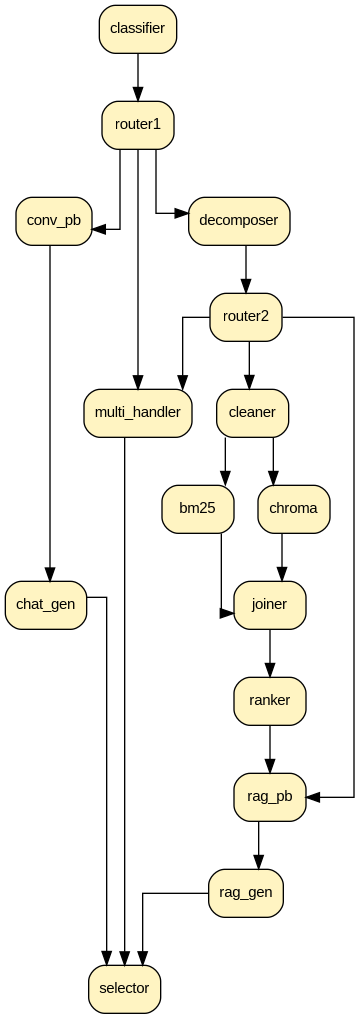

In [18]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
from IPython.display import Image

# 1. копия графа и «читаемые» подписи
H = pipe.graph.copy()
nice = {
    "router": "router",
    "txt_converter": "TXT",
    "csv_converter": "CSV",
    "md_converter": "MD",
    "json_converter": "JSON",
    "pdf_converter": "PDF",
    "docx_converter": "DOCX",
    "xlsx_converter": "XLSX",
    "tika_doc_converter": "DOC",
    "tika_epub_converter": "EPUB",
    "tika_xls_converter": "XLS",
    "tika_unclassified_converter": "fallback",
    "join": "join",
    "cleaner": "cleaner",
    "splitter": "splitter",
    "overlap_fix": "overlap_fix",
    "embedder": "embedder",
    "writer": "writer",
}
nx.relabel_nodes(H, nice, copy=False)

# 2. в Graphviz‑объект
A = to_agraph(H)
A.graph_attr.update(rankdir="TB", splines="ortho", bgcolor="white")

# стиль узлов
A.node_attr.update(shape="box", style="filled,rounded", fillcolor="#fff4c2",
                   fontname="Arial", fontsize="11")

# 3. сохраняем/показываем
A.draw("pipeline.png", prog="dot")      # SVG → .svg    PNG → .png
display(Image(filename="pipeline.png")) # Jupyter


DEBUG:haystack.core.pipeline.draw:Mermaid diagram:

%%{ init: {"theme": "neutral"} }%%

graph TD;

classifier["<b>classifier</b><br><small><i>QueryClassifierLLM</i></small>"]:::component -- "need_search -> need_search<br><small><i>bool</i></small>" --> router1["<b>router1</b><br><small><i>ConditionalRouter</i></small>"]:::component
router1["<b>router1</b><br><small><i>ConditionalRouter</i></small>"]:::component -- "no_search -> query<br><small><i>str</i></small>" --> conv_pb["<b>conv_pb</b><br><small><i>ChatPromptBuilder<br><br>Optional inputs:<ul style='text-align:left;'><li>template (Optional[List[ChatMessage]])</li><li>template_variables (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component
router1["<b>router1</b><br><small><i>ConditionalRouter</i></small>"]:::component -- "to_search -> query<br><small><i>str</i></small>" --> decomposer["<b>decomposer</b><br><small><i>QueryDecomposerLLM</i></small>"]:::component
router1["<b>router1</b><br><small><i>ConditionalRouter</i></sm

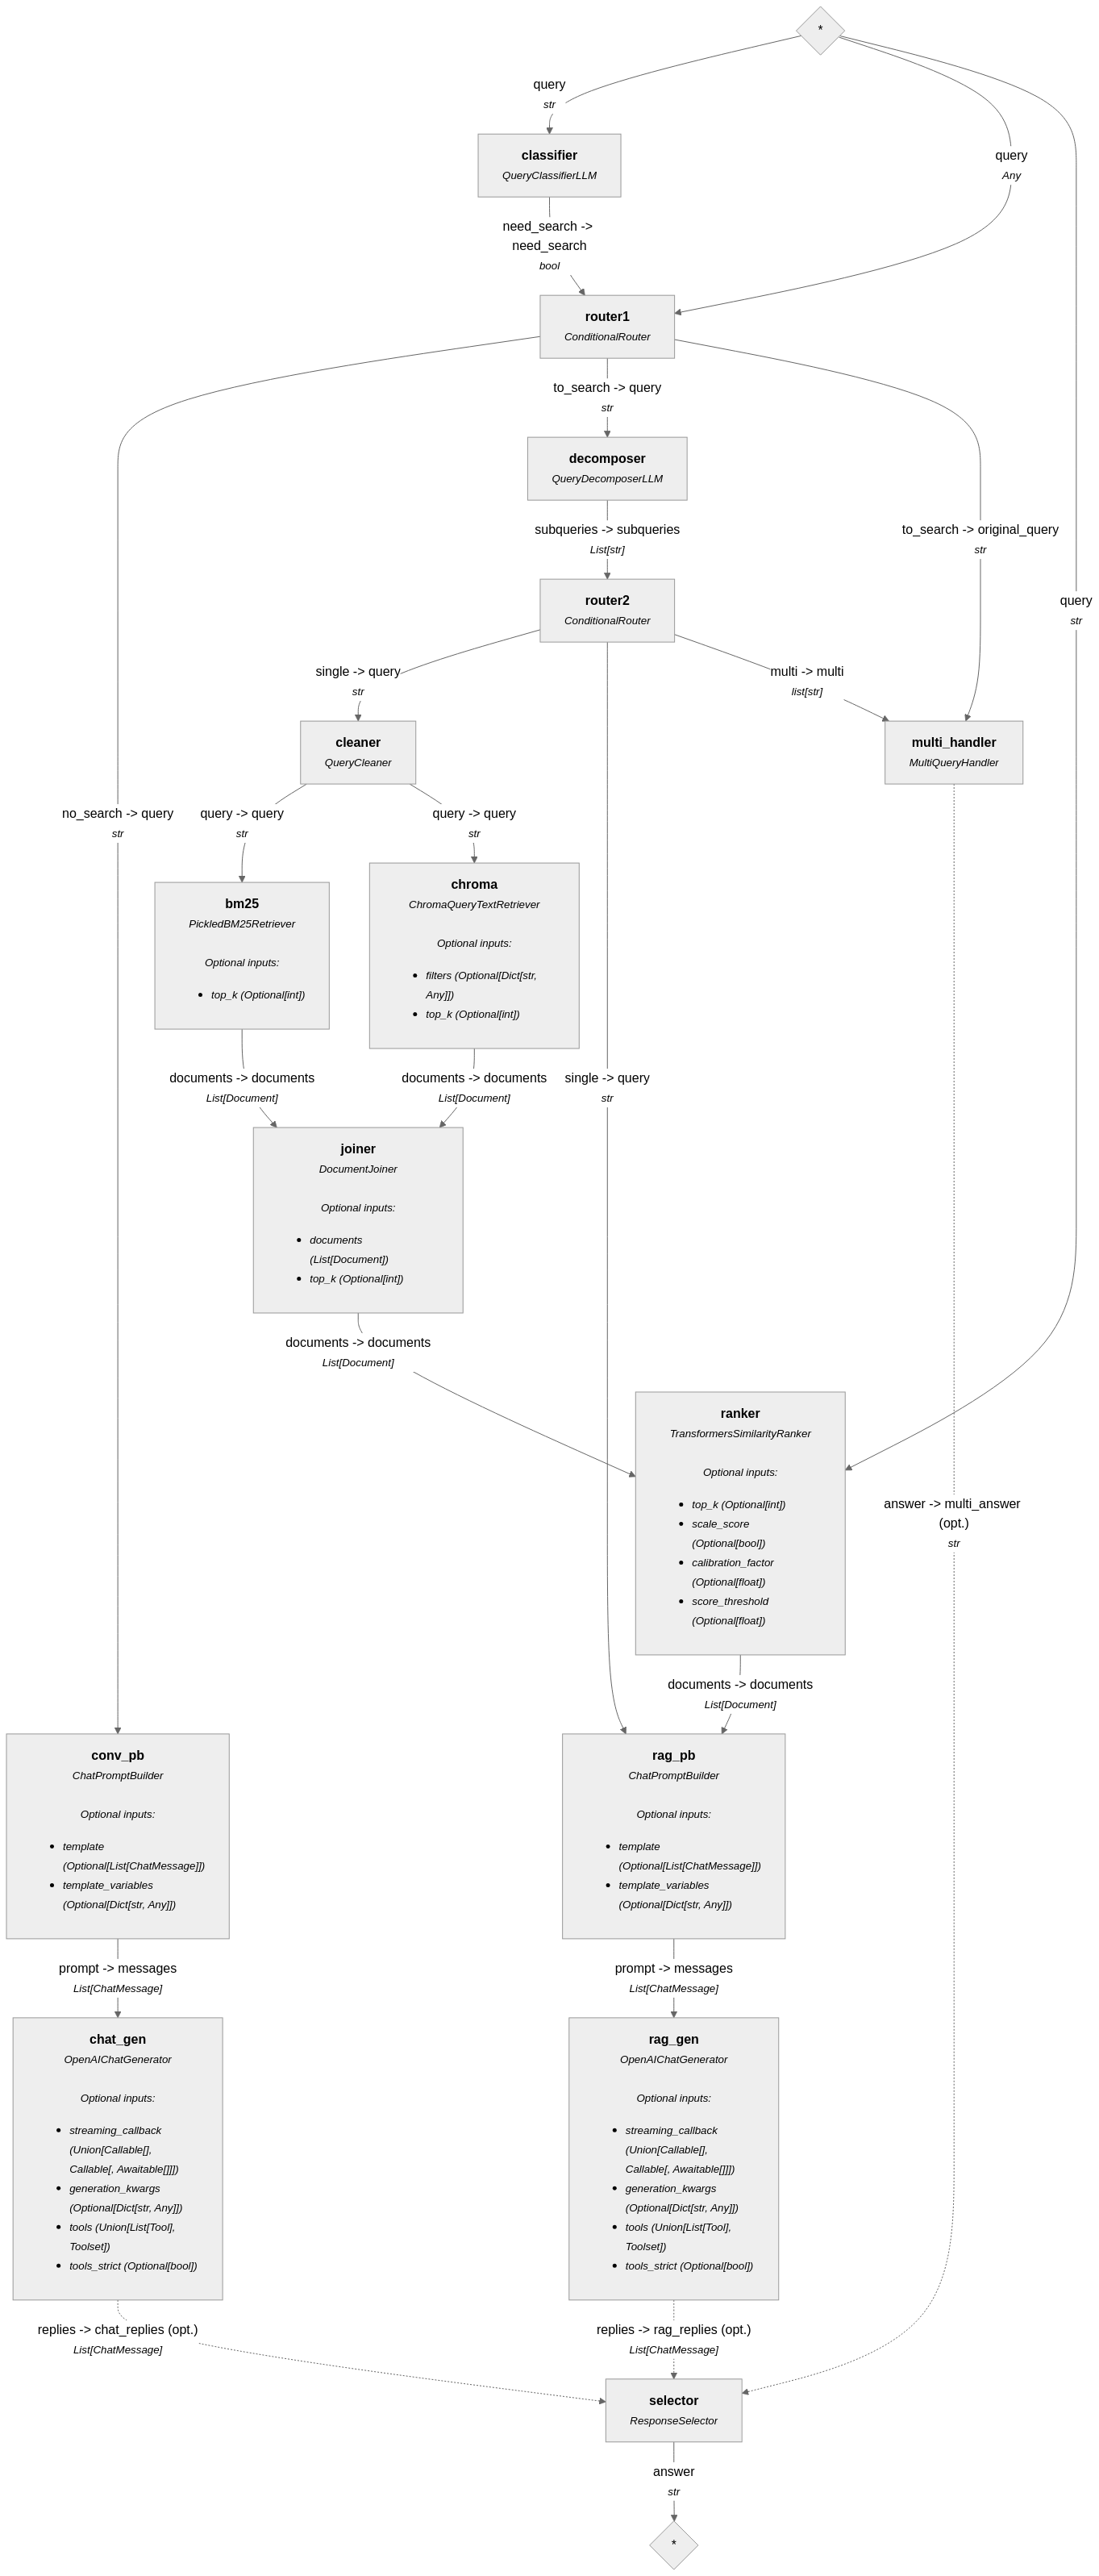

In [8]:
pipe.show()

In [19]:
# # Список тестовых запросов
# test_queries = [
#     "Привет!",
#     "Как дела?",
#     "Что такое тестирование кода?",
#     "Спасибо за помощь.",
#     "Пока!",
#     "Что ты умеешь?",
#     "Где найти инструкцию по подаче заявления на льготы?",
#     "Сколько дней отпуска положено сотрудникам?",
#     "Расскажи о новых политиках отпуска и сколько дней теперь положено?",
#     "Какие льготы предоставляет компания и как их оформить?",
#     "Как мне сформировать отчёт по KPI за месяц и какие метрики включить?",
#     "Какие интеграции поддерживает наше HR‑приложение и как их настроить?",
#     "Какие документы нужны для продления визы?",
#     "Какова зарплатная вилка для позиции Data Scientist?",
#     "Расскажи о политике командировок: куда подавать заявку и какие документы нужны?",
# ]

# for query in test_queries:
#     result = pipe.run({"query": query})
#     answer = result["selector"]["answer"]
#     print(f"Запрос: {query}\nОтвет: {answer}\n{'─'*60}\n")

In [20]:

query = "Привет"
result = pipe.run({"query": query})
answer = result["selector"]["answer"]
print(f"Запрос: {query}\nОтвет: {answer}\n{'─'*60}\n")

INFO:haystack.core.pipeline.base:Warming up component ranker...
INFO:haystack.core.pipeline.pipeline:Running component classifier
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'timeout': 240, 'files': None, 'json_data': {'messages': [{'role': 'user', 'content': 'Ты — классификатор запросов по базе знаний.\nЕсли запрос требует поиска — ответь \'true\'. Если можно ответить без поиска — \'false\'.\n\nПримеры:\nЗапрос: "Привет"\nОтвет: false\n\nЗапрос: "Как дела?"\nОтвет: false\n\nЗапрос: "Что такое GDPR?"\nОтвет: true\n\nЗапрос: "Сколько дней отпуска положено сотрудникам?"\nОтвет: true\n\nТеперь классифицируй:\nЗапрос: "Привет"\nОтвет:'}], 'model': 'hf.co/IlyaGusev/saiga_yandexgpt_8b_gguf:Q4_0', 'max_tokens': 500, 'n': 1, 'stream': False, 'temperature': 0.8}}
DEBUG:openai._base_client:Sending HTTP Request: POST http://localhost:11434/v1/chat/completions
DEBUG:httpcore.connection:connect_tcp.started host='localhost' port=11434 local_address=None 

Запрос: Привет
Ответ: Привет! Как я могу помочь?
────────────────────────────────────────────────────────────



In [21]:
query = "Как мне сформировать отчёт по KPI за месяц и какие метрики включить?"
result = pipe.run({"query": query})
answer = result["selector"]["answer"]
print(f"Запрос: {query}\nОтвет: {answer}\n{'─'*60}\n")

INFO:haystack.core.pipeline.base:Warming up component ranker...
INFO:haystack.core.pipeline.pipeline:Running component classifier
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'timeout': 240, 'files': None, 'json_data': {'messages': [{'role': 'user', 'content': 'Ты — классификатор запросов по базе знаний.\nЕсли запрос требует поиска — ответь \'true\'. Если можно ответить без поиска — \'false\'.\n\nПримеры:\nЗапрос: "Привет"\nОтвет: false\n\nЗапрос: "Как дела?"\nОтвет: false\n\nЗапрос: "Что такое GDPR?"\nОтвет: true\n\nЗапрос: "Сколько дней отпуска положено сотрудникам?"\nОтвет: true\n\nТеперь классифицируй:\nЗапрос: "Как мне сформировать отчёт по KPI за месяц и какие метрики включить?"\nОтвет:'}], 'model': 'hf.co/IlyaGusev/saiga_yandexgpt_8b_gguf:Q4_0', 'max_tokens': 500, 'n': 1, 'stream': False, 'temperature': 0.8}}
DEBUG:openai._base_client:Sending HTTP Request: POST http://localhost:11434/v1/chat/completions
DEBUG:httpcore.http11:send_requ

Запрос: Как мне сформировать отчёт по KPI за месяц и какие метрики включить?
Ответ: 
Чтобы сформировать полный и комплексный отчет по KPIs за месяц, необходимо учитывать все вышеперечисленные аспекты. Вот примерный план структуры такого отчета:

**1. Введение:**
- Цель исследования
- Основные задачи
- Краткий обзор методологии анализа данных

**2. Методология сбора данных:**
- Источник данных (системы учета рабочего времени, опрос клиентов и участников проекта)
- Методы сбора информации (опросная форма, API интеграции)
- Инструменты для обработки данных (Excel, Power BI, Tableau)

**3. Анализ собранных данных:**
- Визуализация основных метрик (графики, дашборды)
- Выявленные тренды и закономерности за месяц
- Сравнение с предыдущими периодами
- Построение прогнозных моделей при необходимости

**4. Расчет KPIs:**
- Конкретные формулы расчета по каждому KPI
- Результаты расчетов
- Соответствие расчетных значений установленным стандартам компании

**5. Отчетность:**
- Структурированная та

In [ ]:
query = "какие документы нужны для оформления визы?"
result = pipe.run({"query": query})
answer = result["selector"]["answer"]
print(f"Запрос: {query}\nОтвет: {answer}\n{'─'*60}\n")